# Hypothesis Testing

Lukas Graz  
February 13, 2025

In [ ]:
#| code-fold: true
source("R/data_prep.R")

Number of matches per filter criteria (not disjoint)
  Headphone  PRS_all_NA    Distance Activity_NA    Duration  HMNoise_NA 
        303         226         221         102          96          96 
JourneyTime 
         20 
Keep  1494 of 2206 observations

Imputing PRS_orig_vars

## Linear Modeling

### Imputation with MissForest on Training Data

In [ ]:
#| code-fold: true
#| code-summary: "Number of NAs in Mediators and GIS variables"
sapply(D[Mediator_vars], \(x) sum(is.na(x)))

 FEELNAT   LNOISE LOC_SENS LOC_SOUN LOC_SCEN LOC_VISE LOC_VEGE LOC_FAUN 
      16      291       28       30       36       62       69       88 

  LCARTIF_sqrt  LCFOREST_sqrt          HETER    OVDIST_sqrt     VIS5K_sqrt 
             0              0              0              0              0 
       RL_NDVI       RL_NOISE    DISTKM_sqrt   JNYTIME_sqrt STRIMP123_sqrt 
             0              0              0             86              0 
STRIMP999_sqrt 
             0 

In [ ]:
#| code-fold: true
#| code-summary: "Impute missing values using MissForest"
# Mediator imputation
D_trn[Mediator_vars] <- xfun::cache_rds({
  missForest(as.matrix(D_trn[Mediator_vars]))
  }, 
  file = "Mediator_imputation.rds", 
  dir = "cache/",
  hash = list(as.matrix(D_trn[Mediator_vars]))
)$ximp |> as.data.frame()

# GIS imputation (missForest)
D_trn[GIS_vars] <- xfun::cache_rds({
  missForest(as.matrix(D_trn[GIS_vars]))
  }, 
  file = "GIS_imputation.rds", 
  dir = "cache/",
  hash = list(as.matrix(D_trn[GIS_vars]))
)$ximp |> as.data.frame()

### Scaling Test Data

In [ ]:
#| code-fold: true
#| code-summary: "Scaling variables and show old scale"
all_vars <- c(Mediator_vars, GIS_vars, PRS_vars)
old_scale <- t(sapply(D_tst[c(all_vars)], \(x) 
  c(mean = mean(x, na.rm = TRUE), sd = sd(x, na.rm = TRUE))))

D_tst[c(all_vars)] <- lapply(D_tst[c(all_vars)], scale)
D_trn_scaled <- D_trn
D_trn_scaled[c(all_vars)] <- lapply(D_trn[c(all_vars)], scale)

old_scale

                 mean     sd
FEELNAT         6.142  1.055
LNOISE          4.210  0.747
LOC_SENS        4.098  1.016
LOC_SOUN        4.296  0.947
LOC_SCEN        3.967  1.056
LOC_VISE        4.080  1.027
LOC_VEGE        4.343  0.859
LOC_FAUN        3.298  1.365
LCARTIF_sqrt    0.271  0.269
LCFOREST_sqrt   0.454  0.311
HETER           1.305  0.402
OVDIST_sqrt    21.797 10.144
VIS5K_sqrt      3.323  1.620
RL_NDVI         0.635  0.202
RL_NOISE       41.615  9.261
DISTKM_sqrt     1.473  1.156
JNYTIME_sqrt    3.830  2.247
STRIMP123_sqrt  6.555 10.739
STRIMP999_sqrt 47.557 13.162
MEAN            4.987  0.882
FA              5.266  1.111
BA              5.141  1.157
EC              4.542  1.290
ES              5.006  1.430

### Testing VIF

In [ ]:
#| code-fold: true
#| code-summary: "VIF: PRS ~ Mediators + GIS_vars  (NO interaction)"
car::vif(fit_PRS_MED <- lm(as.formula(paste0(
  PRS_vars[1], 
  " ~ ", 
  paste(Mediator_vars, collapse = " + "), " + ",
  paste(GIS_vars,      collapse = " + ")
)), D_trn)) |> summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.21    1.46    1.94    2.03    2.24    4.99 

In [ ]:
#| code-fold: true
#| code-summary: "VIF: PRS ~ (Mediators + GIS_vars)^2 (WITH interaction)"
suppressMessages(
car::vif(fit_PRS_MED <- lm(as.formula(paste0(
  PRS_vars[1], 
  " ~ ", 
  "(", paste(Mediator_vars, collapse = " + "), 
     " + ", paste(GIS_vars, collapse = " + "), 
  ")^2"
)), D_trn))) |> summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   11.9    81.4   147.6   204.9   270.7  1391.7 

Since we model *with* interactions later, the latter VIF are relevant for us. Given that they are very high (c.f. median and max), we would have no hope of finding any significant results in the full interaction model. Therefore, we will first perfom a variable selection, to reduce the VIF and enable us to find significant effects.

### All Interactions: Mediators ~ (GIS)^2

In [ ]:
#| code-fold: true
#| code-summary: "Code: Print Coef Table"

# Elegant function to create coefficient tables from model summaries
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

In [ ]:
Res3 <- list()
for (mediator in Mediator_vars) {
  intercept_model <- lm(as.formula(paste0(
    mediator, " ~ 1")), D_trn)
  step_model <- step(intercept_model, 
    scope = as.formula(paste0(
      mediator, " ~ ", 
      "(", paste(GIS_vars, collapse = " + "), ")^2"
    )),
    trace = FALSE, k = log(nrow(D_trn))
  )
  Res3[[mediator]] <- lm(formula(step_model), D_tst)
}
(ResSum3 <- lapply(Res3, summary))

$FEELNAT

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-4.959 -0.391  0.264  0.607  1.685 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.0618     0.0410    1.51  0.13260    
LCARTIF_sqrt          -0.1524     0.0570   -2.67  0.00770 ** 
RL_NDVI                0.1498     0.0436    3.43  0.00063 ***
OVDIST_sqrt            0.0270     0.0452    0.60  0.55112    
LCARTIF_sqrt:RL_NDVI   0.1146     0.0402    2.85  0.00446 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.948 on 733 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:  0.106, Adjusted R-squared:  0.101 
F-statistic: 21.8 on 4 and 733 DF,  p-value: <2e-16


$LNOISE

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-3.999 -0.527  0.012  0.676  1.622 

Coefficients:
             Estimate 

#### Visualization of Interactioneffect of LCARTIF_sqrt \* RL_NDVI

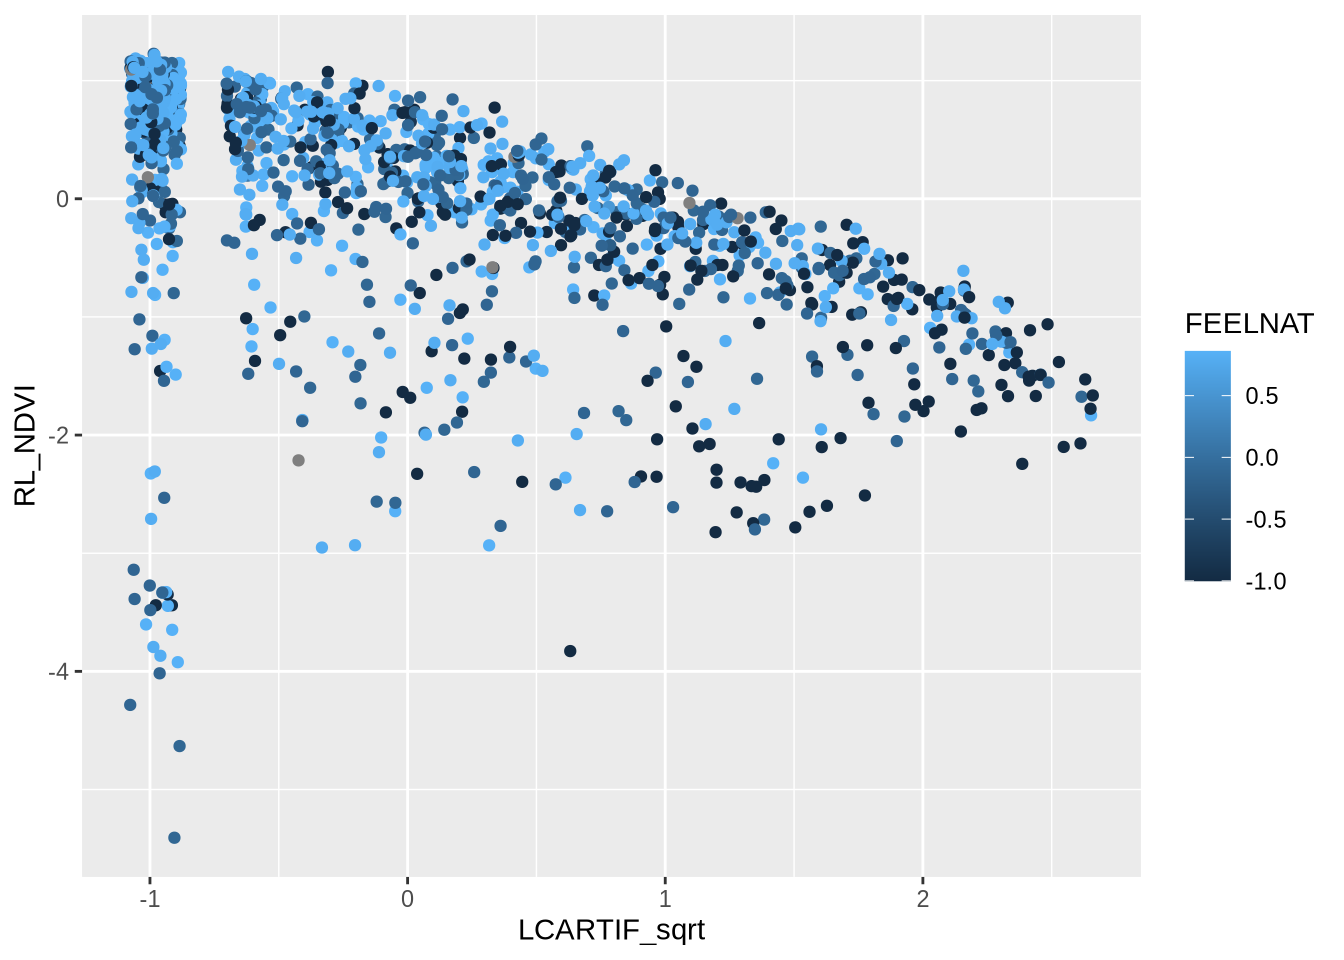

Warning in geom_point(width = 0.07, alpha = 0.6): Ignoring unknown parameters:
`width`

`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

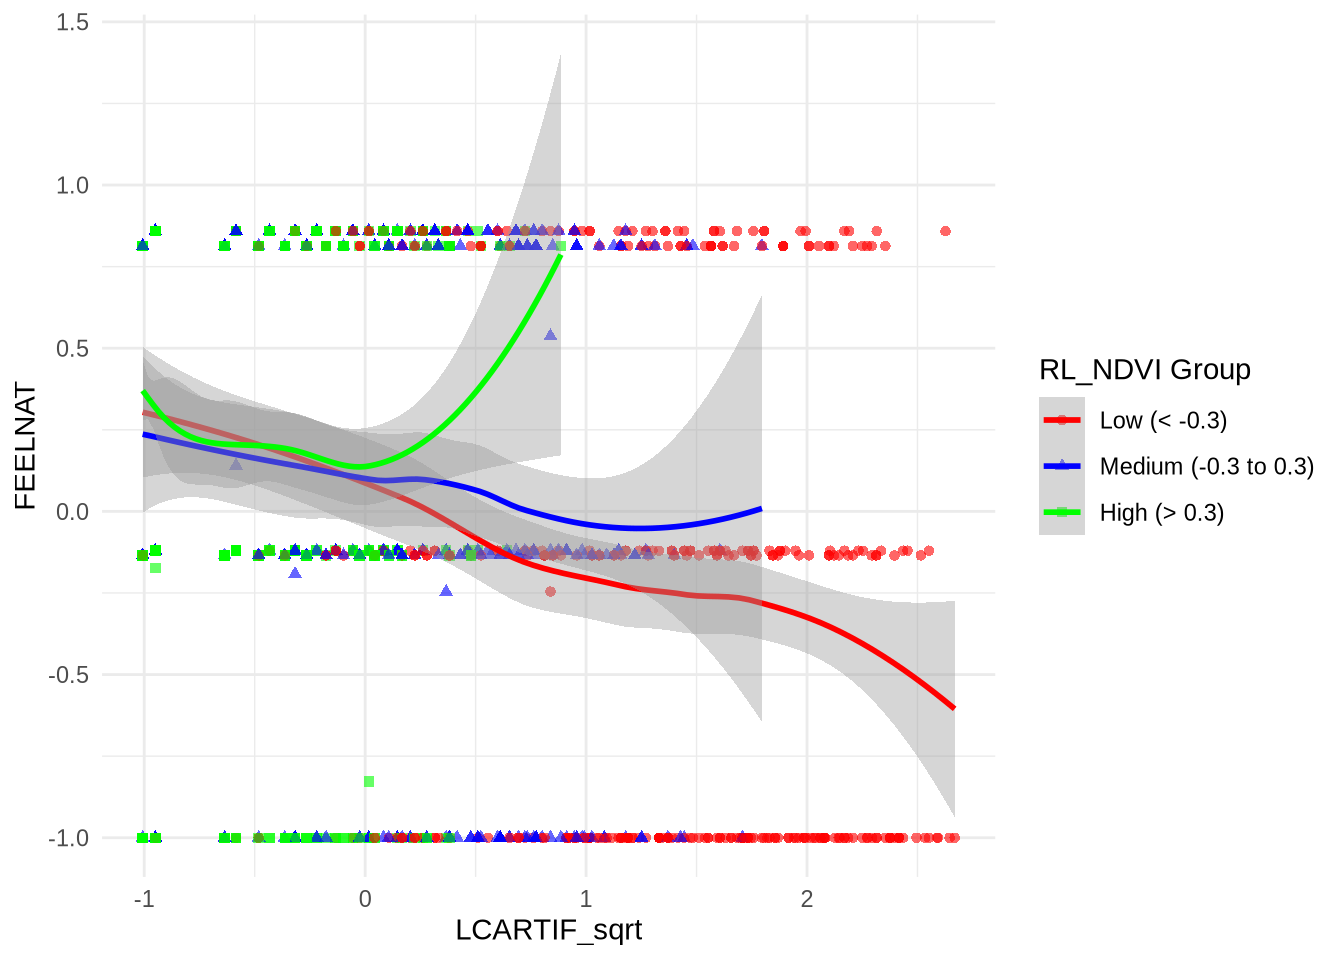

In [ ]:
#| echo: false
#| warning: false

library(ggplot2)
D_plot <- rbind(D_trn_scaled, D_tst)
D_plot$FEELNAT <- pmax(-1,pmin(1,D_plot$FEELNAT))
ggplot(D_plot, aes(x = LCARTIF_sqrt, y=RL_NDVI, col = FEELNAT)) +
  geom_jitter(width=0.07)

### All Interactions: PRS ~ (Mediators + GIS)^2

In [ ]:
Res4 <- list()
for (prs in PRS_vars) {
  intercept_model <- lm(as.formula(paste0(
    prs, " ~ 1")), D_trn)
  step_model <- step(intercept_model, 
    scope = as.formula(paste0(
      prs, " ~ ", 
      "(", paste(GIS_vars, collapse = " + "), " + ", 
      paste(Mediator_vars, collapse = " + "), ")^2"
    )),
    trace = FALSE, k = log(nrow(D_trn))
  )
  Res4[[prs]] <- lm(formula(step_model), D_tst)
}
(ResSum4 <- lapply(Res4, summary))

$MEAN

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8609 -0.5631 -0.0386  0.5998  2.7647 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.00762    0.03787   -0.20    0.841    
LOC_VISE          0.17314    0.04201    4.12  4.3e-05 ***
FEELNAT           0.20198    0.04293    4.70  3.2e-06 ***
LOC_SENS          0.10408    0.04234    2.46    0.014 *  
LNOISE            0.17667    0.04049    4.36  1.5e-05 ***
FEELNAT:LOC_SENS  0.05398    0.02793    1.93    0.054 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.893 on 567 degrees of freedom
  (174 observations deleted due to missingness)
Multiple R-squared:  0.192, Adjusted R-squared:  0.184 
F-statistic: 26.9 on 5 and 567 DF,  p-value: <2e-16


$FA

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-3.391 -0.518  0.093  0.592  2.567

### Table Summarizing Coefficients

Significant codes as usual: `0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1`

#### All Interactions: Mediators ~ (GIS)^2

In [ ]:
#| echo: false
#| output: asis
ResTab3 <- create_coef_table(ResSum3)
saveRDS(ResTab3, "cache/ResSum3.rds")
ResTab3

  --------------------------------------------------------------------------------------------------------------------------------------
  Covariate                 FEELNAT        LNOISE       LOC_SENS       LOC_SOUN      LOC_SCEN     LOC_VISE    LOC_VEGE       LOC_FAUN
  ---------------------- ------------- -------------- ------------- -------------- ------------- ---------- ------------- --------------
  (Intercept)                0.062         -0.001        -0.000         0.000         -0.001       -0.000      -0.019         -0.001

  HETER                                                0.130\*\*\*    0.109\*\*                                           

  JNYTIME_sqrt                                                                                               -0.114\*\*   

  LCARTIF_sqrt            -0.152\*\*      -0.124\*                   -0.175\*\*\*                 -0.071.                  -0.214\*\*\*

  LCARTIF_sqrt:RL_NDVI     0.115\*\*                                                                                      

  OVDIST_sqrt                0.027                                                                                        

  RL_NDVI                 0.150\*\*\*                                               0.217\*\*\*              0.219\*\*\*  

  RL_NOISE                              -0.242\*\*\*                                                                      

  STRIMP999_sqrt                                         -0.073.                                                          
  --------------------------------------------------------------------------------------------------------------------------------------


#### PRS ~ (Mediators + GIS)^2

In [ ]:
#| echo: false
#| output: asis
ResTab4 <- create_coef_table(ResSum4)
saveRDS(ResTab4, "cache/ResSum4.rds")
ResTab4

  -----------------------------------------------------------------------------------------
  Covariate              MEAN            FA            BA            EC            ES
  ------------------ ------------- -------------- ------------- ------------- -------------
  (Intercept)           -0.008         -0.003        -0.008        -0.009         0.031

  DISTKM_sqrt                                                                    0.081\*

  FEELNAT             0.202\*\*\*   0.169\*\*\*    0.188\*\*\*                 0.258\*\*\*

  FEELNAT:LOC_SCEN                     -0.002                                 

  FEELNAT:LOC_SENS      0.054.                                                

  LCFOREST_sqrt                                                   -0.090\*    

  LNOISE              0.177\*\*\*   0.133\*\*\*                                 0.133\*\*

  LNOISE:FEELNAT                                                                 -0.006

  LOC_FAUN                          0.176\*\*\*                               

  LOC_SCEN                          0.164\*\*\*                     0.004     

  LOC_SENS              0.104\*                    0.147\*\*\*   0.142\*\*\*     0.096\*

  LOC_VISE            0.173\*\*\*    0.128\*\*      0.122\*\*                 

  RL_NDVI                           -0.133\*\*\*                              

  RL_NDVI:LOC_SCEN                     0.024                                  
  -----------------------------------------------------------------------------------------


### Legacy Code

In [ ]:
#| code-fold: true
#| code-summary: "Variable selection over multiple y (not desired)"
#| echo: false
#| eval: false

# library(grpreg)
# fit <- cv.grpreg(X = model.matrix(fit_MED_GIS)[,-1], y = D_trn[Mediator_vars[1:2]])
# coef(fit) |> t()
# fit$beta
# plot(fit)

In [ ]:
#| code-fold: true
#| code-summary: "Linear models with mice"
#| echo: false
#| eval: false

Y <- D[]

library(mice, quietly = TRUE)
library(car, quietly = TRUE)
library(miceadds, quietly = TRUE)
data(nhanes2, package = "mice")
set.seed(9090)

mi.res <- miceadds::mice.1chain(nhanes2, burnin = 4, iter = 20, Nimp = 8)
an2a <- miceadds::mi.anova(mi.res = mi.res, formula = "bmi ~ age * chl")

mod1 <- with(mi.res, stats::lm(bmi ~ age * chl))
mod0 <- with(mi.res, stats::lm(bmi ~ age + chl))

mitml::testModels(model = mod1$analyses, null.model = mod0$analyses, method = "D1")
mitml::testModels(model = mod1$analyses, null.model = mod0$analyses, method = "D2")

an2b <- miceadds::mi.anova(mi.res = mi.res, formula = "bmi ~ age * chl", type = 3)

In [ ]:
#| code-fold: true
#| code-summary: "Mediators ~ GIS"
#| echo: false
#| eval: false
stop("this should not run")
Res1 <- list()
for (mediator in Mediator_vars) {
  full_model <- lm(as.formula(paste0(
    mediator, " ~ ", 
    "HM_NOISE_nrm * (", paste(GIS_vars, collapse = " + "), ")"
  )), D_trn)
  small_model <- step(full_model, trace = FALSE, k = log(nrow(D_trn)))
  Res1[[mediator]] <- lm(formula(small_model), D_tst)
}
lapply(Res1, summary)

In [ ]:
#| code-fold: true
#| code-summary: "PRS ~ Mediators"
#| echo: false
#| eval: false
Res2 <- list()
for (mediator in Mediator_vars) {
  full_model <- lm(as.formula(paste0(
    mediator, " ~ ", 
    "HM_NOISE_nrm * (", paste(GIS_vars, collapse = " + "), ")"
  )), D_trn)
  small_model <- step(full_model, trace = FALSE, k = log(nrow(D_trn)))
  Res2[[mediator]] <- lm(formula(small_model), D_tst)
}
lapply(Res2, summary)

``` rqhlibrary(dplyr)
library(knitr)
library(kableExtra)

# Function to extract coefficients with significance indicators
extract_coef_data <- function(model_name, coef_data) {
  # Extract coefficient names, estimates, and p-values
  coef_names <- rownames(coef_data)
  estimates <- coef_data[, "Estimate"]
  p_values <- coef_data[, "Pr(>|t|)"]
  
  # Format estimates with significance stars
  formatted_coef <- sapply(1:length(estimates), function(i) {
    est_str <- sprintf("%.3f", estimates[i])
    if (p_values[i] < 0.001) {
      paste0("**", est_str, "**")  # Bold for p < 0.001
    } else {
      est_str
    }
  })
  
  # Create data frame
  data.frame(
    Model = model_name,
    Covariate = coef_names,
    Coefficient = formatted_coef,
    stringsAsFactors = FALSE
  )
}

# Manual data entry based on your results
# You would typically extract this from your model objects, but since you have text output:

model_results <- list()

# FEELNAT model
feelnat_coef <- data.frame(
  row.names = c("(Intercept)", "LCARTIF_sqrt", "RL_NDVI", "OVDIST_sqrt", "LCARTIF_sqrt:RL_NDVI"),
  Estimate = c(0.0618, -0.1524, 0.1498, 0.0270, 0.1146),
  `Pr(>|t|)` = c(0.13260, 0.00770, 0.00063, 0.55112, 0.00446),
  check.names = FALSE
)
model_results[["FEELNAT"]] <- extract_coef_data("FEELNAT", feelnat_coef)

# LNOISE model
lnoise_coef <- data.frame(
  row.names = c("(Intercept)", "LCARTIF_sqrt", "RL_NOISE"),
  Estimate = c(-0.00097, -0.12357, -0.24203),
  `Pr(>|t|)` = c(0.980, 0.011, 9.7e-07),
  check.names = FALSE
)
model_results[["LNOISE"]] <- extract_coef_data("LNOISE", lnoise_coef)

# LOC_SENS model
loc_sens_coef <- data.frame(
  row.names = c("(Intercept)", "HETER", "STRIMP999_sqrt"),
  Estimate = c(-0.000148, 0.129769, -0.072664),
  `Pr(>|t|)` = c(0.99678, 0.00073, 0.05837),
  check.names = FALSE
)
model_results[["LOC_SENS"]] <- extract_coef_data("LOC_SENS", loc_sens_coef)

# LOC_SOUN model
loc_soun_coef <- data.frame(
  row.names = c("(Intercept)", "LCARTIF_sqrt", "HETER"),
  Estimate = c(0.000403, -0.175213, 0.109010),
  `Pr(>|t|)` = c(0.9912, 2.9e-06, 0.0035),
  check.names = FALSE
)
model_results[["LOC_SOUN"]] <- extract_coef_data("LOC_SOUN", loc_soun_coef)

# LOC_SCEN model
loc_scen_coef <- data.frame(
  row.names = c("(Intercept)", "RL_NDVI"),
  Estimate = c(-0.00114, 0.21701),
  `Pr(>|t|)` = c(0.97, 3.5e-09),
  check.names = FALSE
)
model_results[["LOC_SCEN"]] <- extract_coef_data("LOC_SCEN", loc_scen_coef)

# LOC_VISE model
loc_vise_coef <- data.frame(
  row.names = c("(Intercept)", "LCARTIF_sqrt"),
  Estimate = c(-0.000356, -0.071106),
  `Pr(>|t|)` = c(0.992, 0.059),
  check.names = FALSE
)
model_results[["LOC_VISE"]] <- extract_coef_data("LOC_VISE", loc_vise_coef)

# LOC_VEGE model
loc_vege_coef <- data.frame(
  row.names = c("(Intercept)", "RL_NDVI", "JNYTIME_sqrt"),
  Estimate = c(-0.0192, 0.2195, -0.1139),
  `Pr(>|t|)` = c(0.6111, 1.4e-08, 0.0027),
  check.names = FALSE
)
model_results[["LOC_VEGE"]] <- extract_coef_data("LOC_VEGE", loc_vege_coef)

# LOC_FAUN model
loc_faun_coef <- data.frame(
  row.names = c("(Intercept)", "LCARTIF_sqrt"),
  Estimate = c(-0.00127, -0.21409),
  `Pr(>|t|)` = c(0.97, 1.1e-08),
  check.names = FALSE
)
model_results[["LOC_FAUN"]] <- extract_coef_data("LOC_FAUN", loc_faun_coef)

# Combine all results
all_results <- do.call(rbind, model_results)

# Create wide format table
results_wide <- all_results %>%
  select(Model, Covariate, Coefficient) %>%
  tidyr::pivot_wider(names_from = Model, values_from = Coefficient, values_fill = "")

# Get all unique covariates and sort them (intercept first)
all_covariates <- unique(all_results$Covariate)
covariate_order <- c("(Intercept)", sort(all_covariates[all_covariates != "(Intercept)"]))

# Reorder rows
results_wide <- results_wide %>%
  slice(match(covariate_order, Covariate))

# Create the final table
print("Linear Model Results Summary")
print("Bold coefficients indicate p < 0.001")
print("")

# Display as a nice table
kable(results_wide, 
      format = "pipe",
      align = c("l", rep("c", ncol(results_wide)-1))) %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed"))

# Alternative: Simple data frame for viewing
print(results_wide)
```